# Pipeline 1: Predicting Volatility and Evaluation

In [68]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import src.util as util
import src.rv as rv
import src.lstm as lstm

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload modules to pick up any changes
importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [71]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
    #   22771: "22771: NFLX XNAS",
    #         104919: "104919: QQQ XNAS",
df_single_stock = combined_df[combined_df["stock_id"] == 22771].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)



In [72]:
np.random.seed(3888)  # for reproducibility
# chosen_ids = np.random.choice(snapshot_features_df['time_id'].unique(), size=2, replace=False)
chosen_ids = [14,246]
print(chosen_ids)

subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(chosen_ids)].copy()


importlib.reload(util)
from src.util import generate_tick_sequences

# Feature columns (same as your model)
feature_cols = [
    "wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
    "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"
]

# Save one .pkl per time_id
stock_id = 22771
for time_id in chosen_ids:
    df_tid = snapshot_features_df[snapshot_features_df["time_id"] == time_id].copy()
    rolling_features_df = util.generate_rolling_features(df_tid)

    # Generate LSTM-ready sequences
    seq_df = generate_tick_sequences(df_tid, feature_cols)

    output_path = f"dashboard/data/dashboard_lstm_{stock_id}_tid{time_id}.pkl"
    seq_df.to_pickle(output_path)
    print(f"✅ Saved {output_path}")


[14, 246]
✅ Saved dashboard/data/dashboard_lstm_22771_tid14.pkl
✅ Saved dashboard/data/dashboard_lstm_22771_tid246.pkl


In [ ]:
df = snapshot_features_df[snapshot_features_df["time_id"] == 246]
print(df["seconds_in_bucket"].min(), df["seconds_in_bucket"].max())

# 1 time id is 1 hour 


0.0 3599.0


In [ ]:

# deciding what time id to use in dashboard 
snapshot_features_df = snapshot_features_df[snapshot_features_df['stock_id'] == 50200]

# Compute std of log return per time_id
vol_per_time = snapshot_features_df.groupby("time_id")["log_return"].std().reset_index()
vol_per_time.columns = ["time_id", "log_return_std"]

# Sort descending
top_ids = vol_per_time.sort_values("log_return_std", ascending=False).head(5)
print(top_ids)



      time_id  log_return_std
228       246        0.000292
810       846        0.000291
96        108        0.000284
264       282        0.000256
1074     1116        0.000235


ModuleNotFoundError: No module named 'model'

In [35]:
# # # select only the first 100 time_id
# subset_time_ids = snapshot_features_df['time_id'].unique()[:5]
# subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

# Get all unique time_ids
all_time_ids = snapshot_features_df['time_id'].unique()

# Exclude the first 5 (e.g. training time_ids)
used_time_ids = all_time_ids[:5]
available_time_ids = np.setdiff1d(all_time_ids, used_time_ids)

# Select 5 random, unused time_ids
np.random.seed(3888)  # for reproducibility
random_time_ids = np.random.choice(available_time_ids, size=5, replace=False)

# Subset the snapshot DataFrame
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(random_time_ids)].copy()

In [36]:
importlib.reload(util)
#  Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(subset_snapshot_df)

In [37]:
from src.util import generate_tick_sequences

# Define features (should match what you used in model training)
feature_cols = [
    "wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
    "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"
]

# Generate LSTM-ready sequences
seq_df = generate_tick_sequences(subset_snapshot_df, feature_cols)

# Save the DataFrame directly
seq_df.to_pickle("dashboard/data/dashboard_lstm_104919_random.pkl")
print(" Saved")


 Saved


In [39]:
import pandas as pd
import numpy as np

# Load your .pkl file
df = pd.read_pickle("dashboard/data/dashboard_lstm_50200_random.pkl")

# Extract X (list of arrays)
X = np.stack(df["X"].values)

# Check stats
print("Shape:", X.shape)  # Should be (num_windows, 330, num_features)
print("Feature mean (first window):", X[0].mean(axis=0))
print("Feature std (first window):", X[0].std(axis=0))
print("Max:", np.max(X))
print("Min:", np.min(X))


tick_counts = df.groupby("time_id").size()
print(tick_counts)



Shape: (3265, 330, 9)
Feature mean (first window): [ 3.72347747e+02  3.72734563e-05 -8.81932862e-02  7.58993868e+00
 -3.43036869e-06 -3.43036869e-06  4.36455183e-05  8.17480816e-02
  1.50303030e+00]
Feature std (first window): [1.52456456e-01 1.30856611e-05 5.04365182e-01 4.44120787e+01
 4.61488953e-05 4.61488953e-05 1.56785693e-05 1.04824630e+00
 9.35082187e+00]
Max: 3619.9963800036203
Min: -10.0
time_id
6     653
7     653
8     653
9     653
10    653
dtype: int64


## RV OLS Baseline

## LSTM

### LSTM Baseline

### LSTM With Features

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Run LSTM Baseline ---
model_lstm_features, history_lstm_features, val_df_lstm_features = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='additional_features'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.9404 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8318 - val_loss: 0.3994 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8099 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7932 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.7775 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7675 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7612 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7558 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7506 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004046
Validation QLIKE: 0.3822
Directional Acc: 0.4228
Average inference time per window: 0.032021 seconds
Model & scalers saved to out/lstm


## Advanced LSTM Model

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_advanced, history_lstm_advanced, val_df_lstm_advanced = lstm.advanced(
    subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    model_name='advanced'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - loss: 0.9337 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 0.9812 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.3151 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.2305 - val_loss: 0.6662 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - loss: 1.1969 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - loss: 1.1402 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - loss: 1.1482 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - loss: 1.0906 - val_loss: 0.6414 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - loss: 1

Final Model MSE: 0.00000000
Final Model RMSE: 0.00005066
Final Model QLIKE: 0.5020
Directional Acc: 0.4699
Avg Inference Time: 0.061351s
Saved final model & scalers to <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>


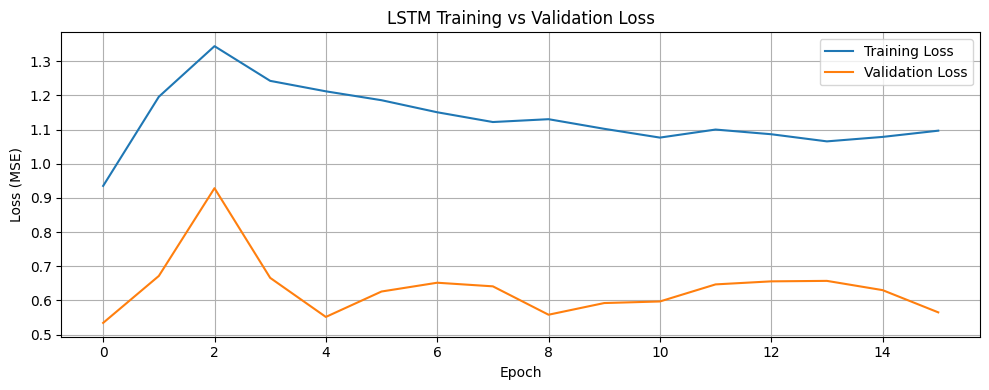

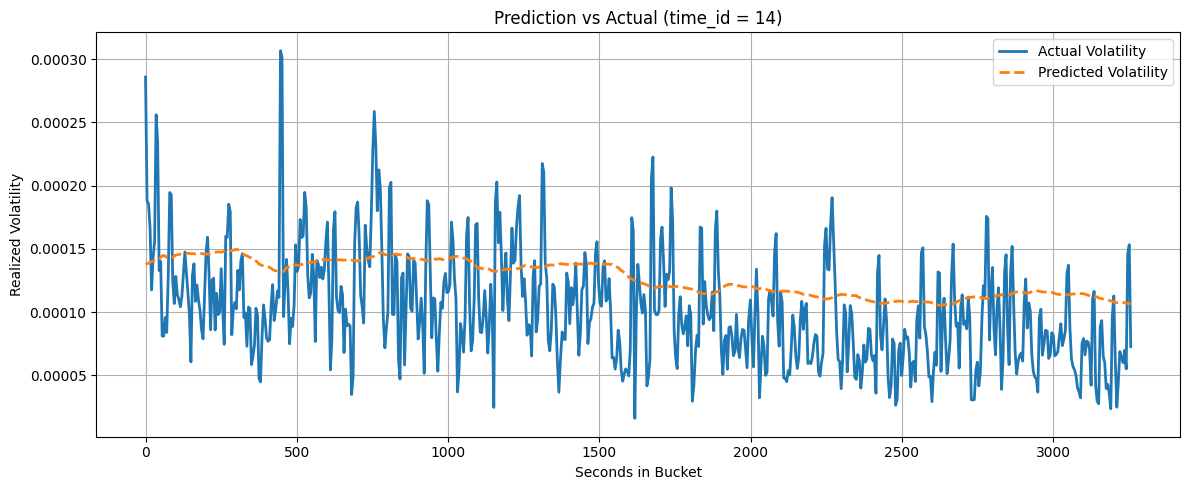

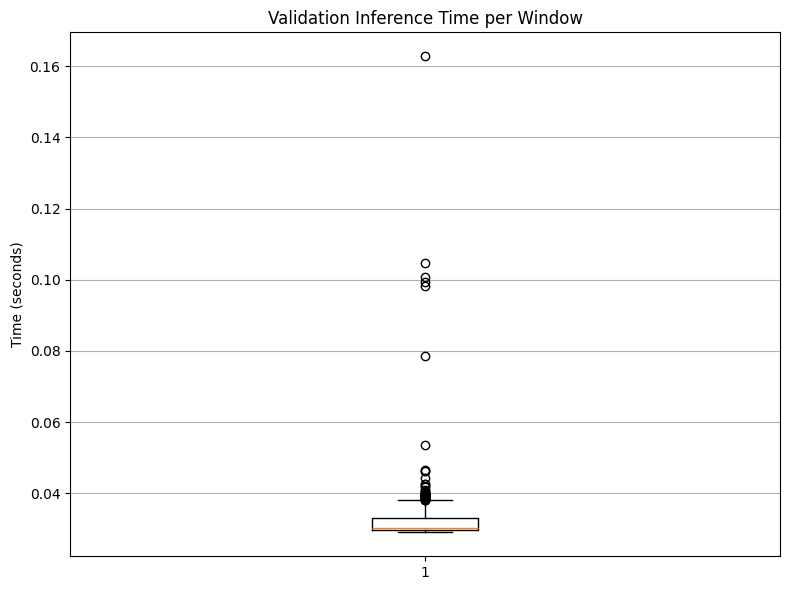

In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_advanced)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_advanced,
    time_id=val_df_lstm_advanced['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

## In Sample Evaluation

                      model           mse      rmse     qlike  \
0              ols_baseline  1.285060e-09  0.000036  0.322214   
1             lstm_baseline  1.791092e-09  0.000042  0.396131   
2  lstm_additional_features  1.637124e-09  0.000040  0.382185   
3             lstm_advanced  2.566615e-09  0.000051  0.501960   

   directional_accuracy  avg_inference_time  
0              0.517975            0.000040  
1              0.365741            0.032856  
2              0.422840            0.032021  
3              0.469907            0.061351  


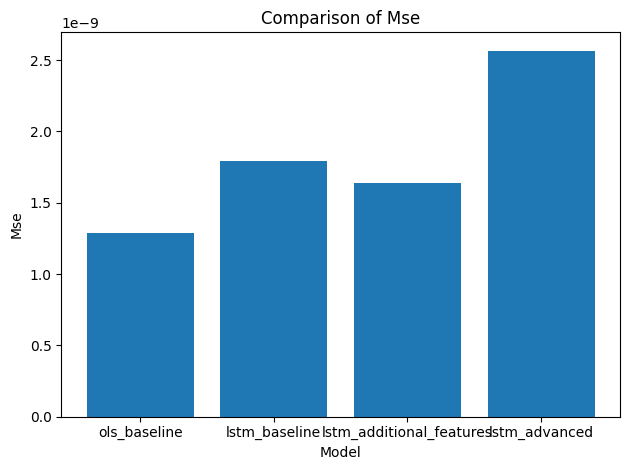

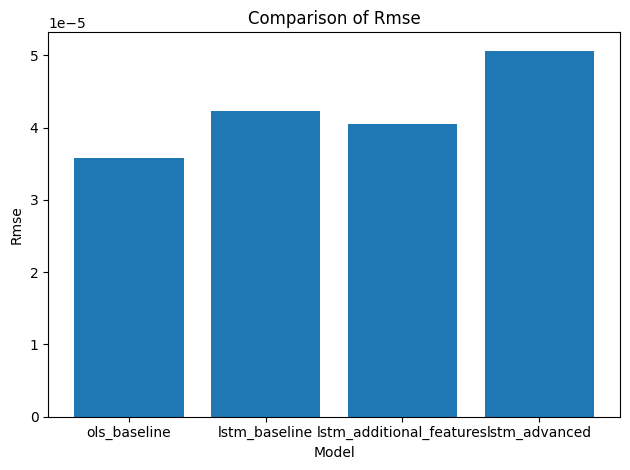

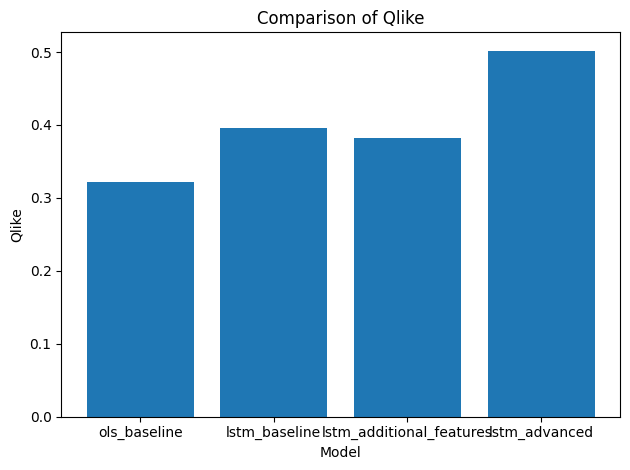

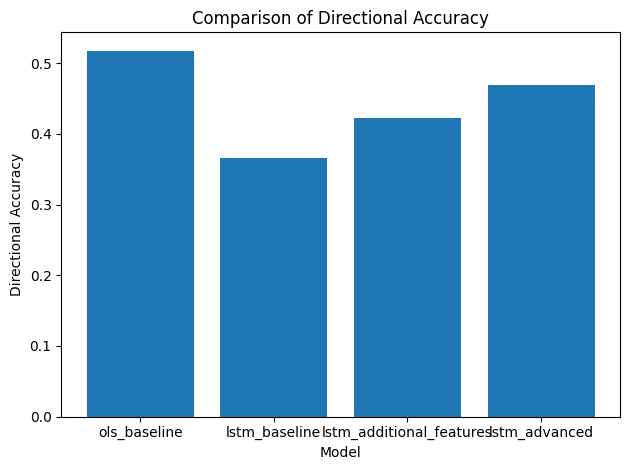

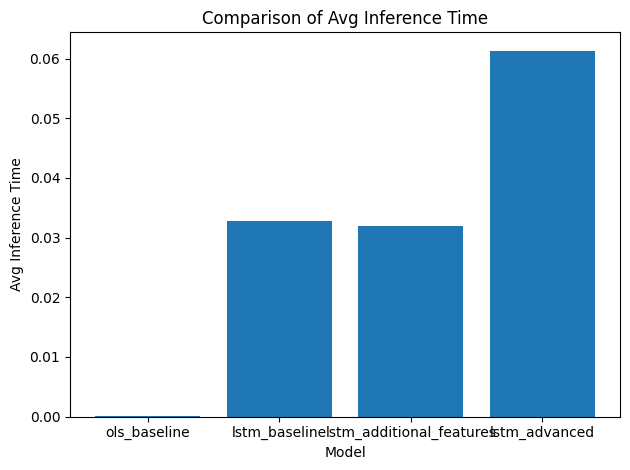

In [ ]:
metrics = []
for name, val_df in [
        ('ols_baseline', test_df_ols),
        ('lstm_baseline', val_df_lstm_baseline),
        ('lstm_additional_features', val_df_lstm_features),
        ('lstm_advanced', val_df_lstm_advanced)
    ]:
    y_true = val_df['y_true'].values
    y_pred = val_df['y_pred'].values
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    qlike = util.qlike_loss(y_true, y_pred)
    directional_acc = util.directional_accuracy(y_true, y_pred)
    avg_inf_time = val_df['inference_time'].mean()
    metrics.append({
        'model': name,
        'mse': mse,
        'rmse': rmse,
        'qlike': qlike,
        'directional_accuracy': directional_acc,
        'avg_inference_time': avg_inf_time
    })

metric_df = pd.DataFrame(metrics)
print(metric_df)

# -------------------------------------------------------------
## Evaluation Metrics
# -------------------------------------------------------------
# Visualise each metric in its own bar chart

# List of metrics to plot (excluding model name)
plot_metrics = ['mse', 'rmse', 'qlike', 'directional_accuracy', 'avg_inference_time']

for metric in plot_metrics:
    plt.figure()
    plt.bar(metric_df['model'], metric_df[metric])
    plt.title(f'Comparison of {metric.replace("_", " ").title()}')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

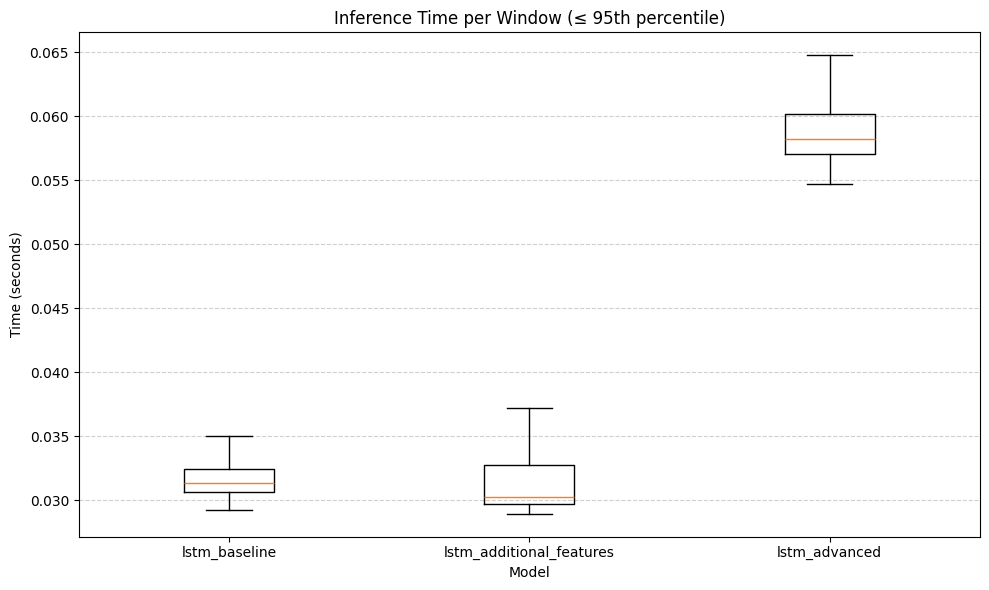

In [ ]:
# Create a dictionary of DataFrames for each model
val_dfs = {
    'lstm_baseline': val_df_lstm_baseline,
    'lstm_additional_features': val_df_lstm_features,
    'lstm_advanced': val_df_lstm_advanced
}

util.plot_side_by_side_inference_boxplots(val_dfs,
                                     inference_col='inference_time',
                                     percentile=95)

## Out of Sample Evaluation

### Highly Correlated Stocks: ID-104919

In [ ]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_high_cor_stock = combined_df[combined_df["stock_id"] == 104919].copy()

snapshot_features_df_high_cor = util.create_snapshot_features(df_high_cor_stock)
snapshot_features_df_high_cor = snapshot_features_df_high_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_high_cor['time_id'].unique()[:10]
subset_snapshot_df_high_cor = snapshot_features_df[snapshot_features_df_high_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'

basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_high_cor, oos_metrics_high_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_high_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_high_cor)
print(val_df_oos_high_cor.head())


Out-of-Sample Metrics: {'mse': 3.276007473664776e-08, 'rmse': 0.00018099744400584158, 'qlike': 4.183757792128442, 'directional_accuracy': 0.519361833952912, 'avg_inference_time': 0.06196931018536619}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.398865
1        6      1802.0  0.000129  0.000106        0.063055
2        6      1805.0  0.000329  0.000106        0.062352
3        6      1807.0  0.000446  0.000105        0.062805
4        6      1810.0  0.000438  0.000106        0.058524


### Lowly Correlated Stocks: ID-22753

In [ ]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_low_cor_stock = combined_df[combined_df["stock_id"] == 22753].copy()

snapshot_features_df_low_cor = util.create_snapshot_features(df_low_cor_stock)
snapshot_features_df_low_cor = snapshot_features_df_low_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_low_cor['time_id'].unique()[:10]
subset_snapshot_df_low_cor = snapshot_features_df_low_cor[snapshot_features_df_low_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_low_cor, oos_metrics_low_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_low_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_low_cor)
print(val_df_oos_low_cor.head())

Out-of-Sample Metrics: {'mse': 3.320566820245771e-08, 'rmse': 0.00018222422507026257, 'qlike': 4.236690438652568, 'directional_accuracy': 0.5194151096669375, 'avg_inference_time': 0.0564814600901018}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.338168
1        6      1802.0  0.000129  0.000106        0.056722
2        6      1805.0  0.000329  0.000106        0.056631
3        6      1807.0  0.000446  0.000105        0.056182
4        6      1810.0  0.000438  0.000106        0.056672


In [ ]:
insample_adv = metric_df.loc[metric_df['model'] == 'lstm_advanced'].iloc[0].to_dict()

comparison_df = pd.DataFrame([
    {'dataset': 'in_sample',             **insample_adv},
    {'dataset': 'out_sample_highcor',   **oos_metrics_high_cor},
    {'dataset': 'out_sample_lowcor',    **oos_metrics_low_cor},
]).set_index('dataset')

display(comparison_df)


,model,mse,rmse,qlike,directional_accuracy,avg_inference_time
dataset,,,,,,
in_sample,lstm_advanced,2.566615e-09,0.000051,0.501960,0.469907,0.061351
out_sample_highcor,NaN,3.276007e-08,0.000181,4.183758,0.519362,0.061969
out_sample_lowcor,NaN,3.320567e-08,0.000182,4.236690,0.519415,0.056481
